# Google Analytics Customer Revenue
## Preprocessing & EDA

## Objectives: 

The main objectives of this project are :

* Load the data so everything is in tabular format (some columns contain JSON so it you will need to find ways to separate those into independent columns)
* Identify the variables that need special processing (removing or infering missing values, removing columns that do not contain useful information)
* Run visualizations to better understand the data

## Presenting the initial data: 

<b>Data Fields: </b>

<b>fullVisitorIdv</b> - A unique identifier for each user of the Google Merchandise Store. <br>
<b>channelGrouping</b> - The channel via which the user came to the Store.<br>
<b>date</b> - The date on which the user visited the Store.<br>
<b>device </b>- The specifications for the device used to access the Store.<br>
<b>geoNetwork</b> - This section contains information about the geography of the user.<br>
<b>sessionId</b> - A unique identifier for this visit to the store.<br>
<b>socialEngagementType</b> - Engagement type, either "Socially Engaged" or "Not Socially Engaged".<br>
<b>totals</b> - This section contains aggregate values across the session.<br>
<b>trafficSource</b> - This section contains information about the Traffic Source from which the session originated.<br>
<b>visitId</b> - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.<br>
<b>visitNumber</b> - The session number for this user. If this is the first session, then this is set to 1.<br>
<b>visitStartTime</b> - The timestamp (expressed as POSIX time).<br>

## Importing necessary libraries

In [1]:
# Necessary to read the dataset from s3
!pip install s3fs -q

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# set a graph style
plt.style.use('fivethirtyeight')

### Let's start by importing the first 50 rows of our dataset to have a look at its structure.

In [3]:
# import a 50 lines sample of our dataset from s3 bucket
s3_path = "s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/preprocessing_linear_models/Google_dataset.csv"
sample_df = pd.read_csv(s3_path, nrows=50)

In [4]:
sample_df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       50 non-null     object
 1   date                  50 non-null     int64 
 2   device                50 non-null     object
 3   fullVisitorId         50 non-null     uint64
 4   geoNetwork            50 non-null     object
 5   sessionId             50 non-null     object
 6   socialEngagementType  50 non-null     object
 7   totals                50 non-null     object
 8   trafficSource         50 non-null     object
 9   visitId               50 non-null     int64 
 10  visitNumber           50 non-null     int64 
 11  visitStartTime        50 non-null     int64 
dtypes: int64(4), object(7), uint64(1)
memory usage: 4.8+ KB


In [6]:
print(sample_df.loc[0, "device"])
type(sample_df.loc[0, "device"])

{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}


str

### Some columns seems to be in Json format. We will need to flatten them, so that key entries become columns of our dataframe.

### We are also going to convert "fullVisitorId" and "visitId" columns into "string" type.

### We will focus on the "date" column later on.

In [7]:
%%time
json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] # Columns that have json format

df = pd.read_csv(s3_path, 
                     converters={column: json.loads for column in json_columns}, # loading the json columns properly
                     dtype={"fullVisitorId": "str", "visitId":"str"})

for column in json_columns:
    # convert json columns to DataFrame
    column_to_df = pd.json_normalize(df[column])
    # set column name using the initial name and keys of json columns
    column_to_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_to_df.columns] 
    # after extracting the values, let drop the original columns
    df = df.drop(column, axis=1).merge(column_to_df, right_index=True, left_index=True)
    
print(f"Loaded {os.path.basename(s3_path)}. Shape: {df.shape}")

Loaded Google_dataset.csv. Shape: (903653, 55)
Wall time: 5min 47s


In [8]:
# display all the columns
pd.set_option('display.max_columns', 500)
# display the first 5 rows
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [9]:
df.tail()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,Not Socially Engaged,1483554750,1,1483554750,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Caribbean,Puerto Rico,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,prtc.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,17,15,NaN,1,NaN,(not set),youtube.com,referral,NaN,not available in demo dataset,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,Not Socially Engaged,1483543798,1,1483543798,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,Sri Lanka,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,18,13,NaN,1,NaN,(not set),youtube.com,referral,NaN,not available in demo dataset,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,Not Socially Engaged,1483526434,1,1483526434,Android Webview,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,24,21,NaN,1,NaN,(not set),youtube.com,referral,NaN,not available in demo dataset,NaN,/yt/about/ko/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,Not Socially Engaged,1483592857,1,1483592864,Chrome,not available in demo dataset,not availab

## Knowing the missing values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  object
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [11]:
# count number of missing values for each column
total_missing_values = df.isnull().sum().sort_values(ascending=False)

# compute percentage of missing value in each column
perc_missing_values = (df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

# concatenate missing values information in a DataFrame
missing_values_df = pd.concat([total_missing_values, perc_missing_values], axis=1,
                              keys=["Count_missing_values", "%_of_missing_values"])

# Return columns with missing values only
print("Column(s) with at least one missing value:\n")
display(missing_values_df[~(missing_values_df["Count_missing_values"] == 0)])

Column(s) with at least one missing value:



,Count_missing_values,%_of_missing_values
trafficSource.campaignCode,903652,99.999889
trafficSource.adContent,892707,98.788694
totals.transactionRevenue,892138,98.725728
trafficSource.adwordsClickInfo.isVideoAd,882193,97.625195
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.page,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.isTrueDirect,629648,69.678073
trafficSource.referralPath,572712,63.377425


## Let's take a look on datatypes of all columns

In [12]:
print("The distribution of columns across types is the following :\n{}\n".format(df.dtypes.value_counts()))
print(df.info())

The distribution of columns across types is the following :
object    51
int64      3
bool       1
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  object
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     

### Let's create a function to handle "date" and "visitStartTime" column

In [13]:
# This function is to extract date features
def processing_date(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting month
    df["year"] = df['date'].dt.year # extracting year
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int) # convert seconds to hours
    
    return df #returning df after the transformations

In [14]:
df = processing_date(df) # process dates in our DataFrame df

df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode,weekday,day,month,year,_visitHour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,17
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,7


### Let's investigate some constant columns

It seems that our DataFrame has constant columns, which means that they contain a unique value. Consequently, they may not give us any useful information. In that case, let's drop them.

In [15]:
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

print(f"Number of constant columns: {len(constant_columns)}\n")
print("Constant columns and their corresponding value:")
df.loc[0, constant_columns]

Number of constant columns: 24

Constant columns and their corresponding value:


socialEngagementType                                          Not Socially Engaged
device.browserVersion                                not available in demo dataset
device.browserSize                                   not available in demo dataset
device.operatingSystemVersion                        not available in demo dataset
device.mobileDeviceBranding                          not available in demo dataset
device.mobileDeviceModel                             not available in demo dataset
device.mobileInputSelector                           not available in demo dataset
device.mobileDeviceInfo                              not available in demo dataset
device.mobileDeviceMarketingName                     not available in demo dataset
device.flashVersion                                  not available in demo dataset
device.language                                      not available in demo dataset
device.screenColors                                  not available in demo dataset
devi

In [16]:
# drop the constant columns
df.drop(constant_columns, axis=1, inplace=True)

### Let's take a look at all columns in the dataset to see how many unique values and what these values are in order to filter out unimportant variables

In [17]:
for column in df.columns:
        print(f"""Name of column: {column}\n
              Value examples: {df[column].unique()[:3]}\n
              % missing values: {round(df[column].isnull().sum() / len(df[column]) * 100, 2)} | Total unique values: {df[column].nunique()}""")
        print("_________________________________")

Name of column: channelGrouping

              Value examples: ['Organic Search' 'Referral' 'Paid Search']

              % missing values: 0.0 | Total unique values: 8
_________________________________
Name of column: date

              Value examples: ['2016-09-02T00:00:00.000000000' '2017-01-26T00:00:00.000000000'
 '2017-06-23T00:00:00.000000000']

              % missing values: 0.0 | Total unique values: 366
_________________________________
Name of column: fullVisitorId

              Value examples: ['1131660440785968503' '377306020877927890' '3895546263509774583']

              % missing values: 0.0 | Total unique values: 714167
_________________________________
Name of column: sessionId

              Value examples: ['1131660440785968503_1472830385' '377306020877927890_1472880147'
 '3895546263509774583_1472865386']

              % missing values: 0.0 | Total unique values: 902755
_________________________________
Name of column: visitId

              Value examples: ['147

### I will drop some of this features and fillna or missing in some of them

In [18]:
columns_to_drop = ["trafficSource.adwordsClickInfo.gclId", "trafficSource.campaign", "trafficSource.referralPath", 
                   "trafficSource.adwordsClickInfo.page", "trafficSource.adwordsClickInfo.slot", 
                   "trafficSource.keyword", "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adContent"]

In [19]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [20]:
print("Total features dropped: ", len(columns_to_drop))
print("Shape after dropping: ", df.shape)

Total features dropped:  8
Shape after dropping:  (903653, 28)


## Deal with missing values

In [21]:
# filling NA's with 1
df['totals.pageviews'].fillna(1, inplace=True)

# filling NA with zero
df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float)

# setting numerical column as integer
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

# setting numerical to float
df["totals.hits"] = df["totals.hits"].astype(float)

# Use MinMaxScaler to normalize the column
scaler = MinMaxScaler()
df["totals.hits"] = scaler.fit_transform(df["totals.hits"].values.reshape(-1, 1))

# normalizing the transaction Revenue
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].apply(lambda x: np.log10(x+1))

# Visualizations
### Revenue
First, let see the distribuition of transactions Revenues

Transaction Revenue Min Value:  4.000043427276863
Transaction Revenue Mean Value:  7.740587897149032
Transaction Revenue Median Value:  7.694166304715695
Transaction Revenue Max Value:  10.364166244566828


C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


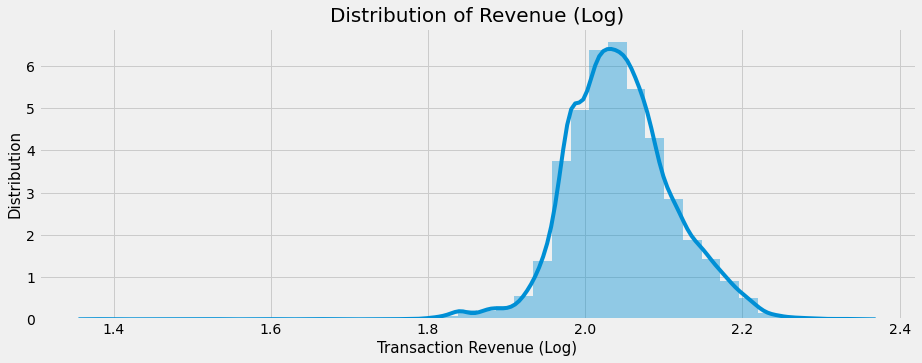

In [22]:
# Printing some statistics of our data
print("Transaction Revenue Min Value: ", 
      df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].min()) # printing the min value
print("Transaction Revenue Mean Value: ", 
      df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].mean()) # mean value
print("Transaction Revenue Median Value: ", 
      df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].median()) # median value
print("Transaction Revenue Max Value: ", 
      df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].max()) # the max value


# seting the figure size of our plot
plt.figure(figsize=(14,5))

# seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
ax = sns.distplot(np.log(df[df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=40, kde=True)
ax.set_xlabel('Transaction Revenue (Log)', fontsize=15) #seting the xlabel and size of font
ax.set_ylabel('Distribution', fontsize=15) #seting the ylabel and size of font
ax.set_title("Distribution of Revenue (Log)", fontsize=20) #seting the title and size of font

plt.show()

### Device Browsers

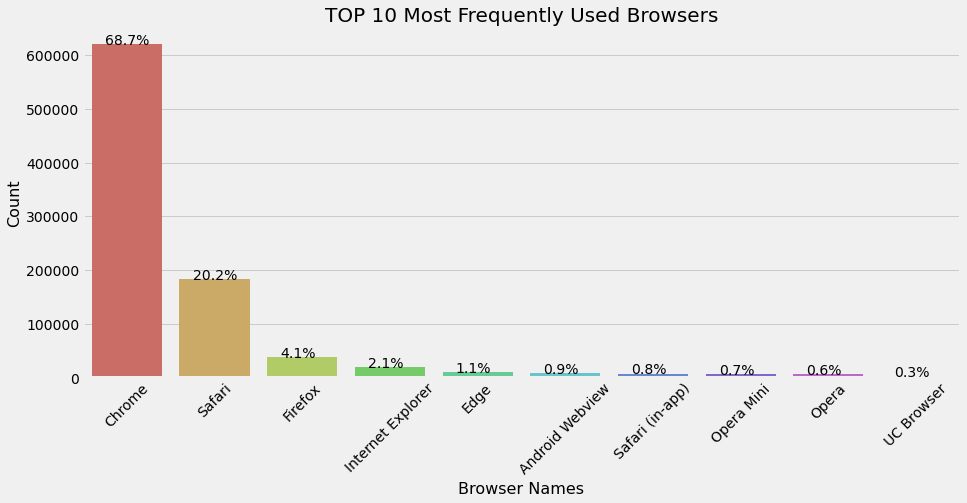

In [23]:
# seting the graph size
plt.figure(figsize=(14, 6))

# Let explore the top 10 browsers used by users
ax = sns.countplot(x="device.browser",data=df, palette="hls", order=df["device.browser"].value_counts()[:10].index)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/ len(df['device.browser']))
    x = p.get_x() + 0.15
    y = p.get_y() + p.get_height() + 200
    ax.annotate(percentage, (x, y))

plt.title("TOP 10 Most Frequently Used Browsers", fontsize=20) # Adding Title and seting the size
plt.xlabel("Browser Names", fontsize=16) # Adding x label and seting the size
plt.ylabel("Count", fontsize=16) # Adding y label and seting the size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show()

## What if we cross the Revenue and Browser?


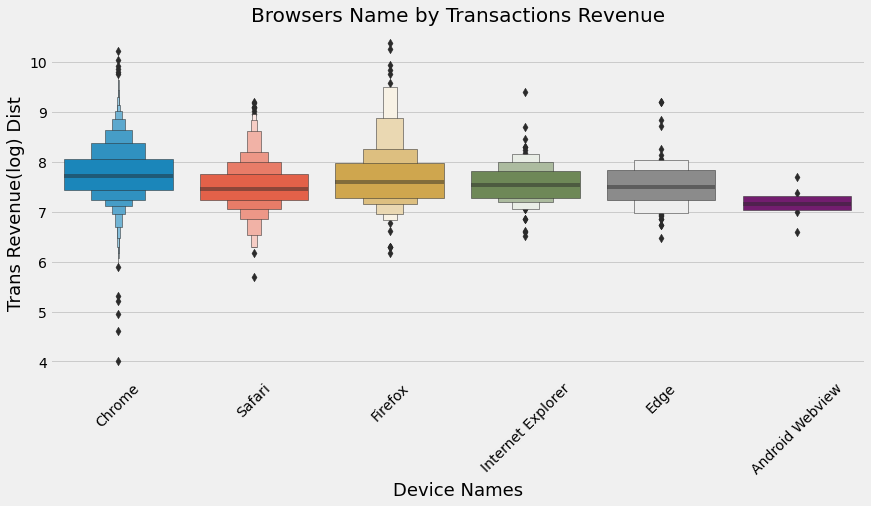

In [24]:
plt.figure(figsize=(13,6)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.boxenplot(x='device.browser', y='totals.transactionRevenue', 
                   data=df[df['totals.transactionRevenue'] > 0], order=(df['device.browser'].value_counts()[:6].index))

g1.set_title('Browsers Name by Transactions Revenue', fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('Device Names', fontsize=18) # Xlabel
g1.set_ylabel('Trans Revenue(log) Dist', fontsize=18) # Ylabel

plt.show()

## Visualization by acquisition channel

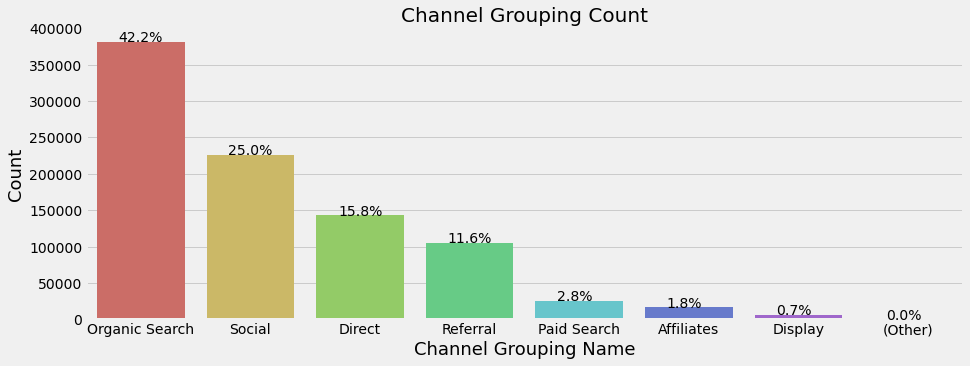

In [25]:
# seting the graph size
plt.figure(figsize=(14, 5))

# let explore the browser used by users
ax = sns.countplot(x="channelGrouping", data=df, palette="hls", order=df["channelGrouping"].value_counts().index)

total = len(df['channelGrouping'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + 0.2
        y = p.get_y() + p.get_height() + 200
        ax.annotate(percentage, (x, y))

plt.title("Channel Grouping Count", fontsize=20) # seting the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

## Crossing Channel Grouping x Browsers

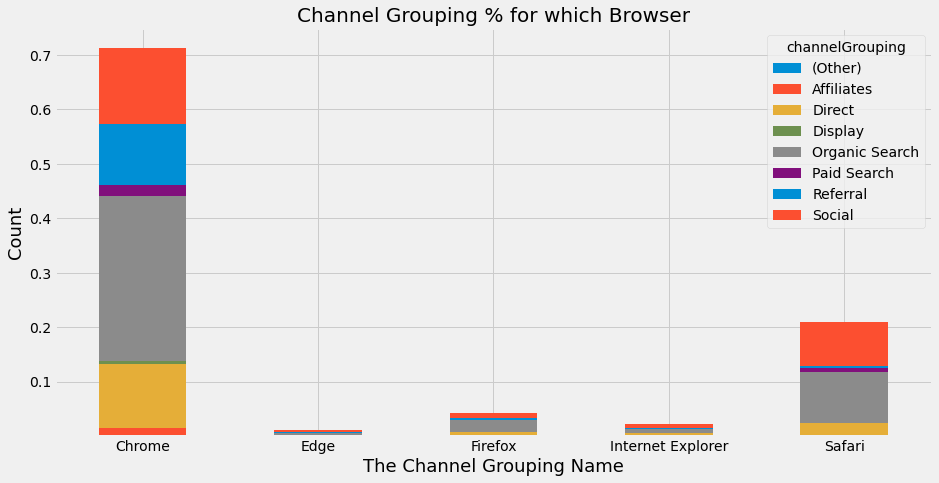

In [26]:
# I will use the crosstab to explore two categorical values

# select just the top 5 of browsers
crosstab_df = pd.crosstab(index=df[df['device.browser']\
                                    .isin(df['device.browser']\
                                    .value_counts()[:5].index)]['device.browser'],
                           normalize=True,
                           columns=df['channelGrouping'])


# Ploting the crosstab that we did above
crosstab_df.plot(kind="bar",
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Channel Grouping % for which Browser", fontsize=20) # seting the title size
plt.xlabel("The Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size
plt.xticks(rotation=0)
plt.show() # rendering

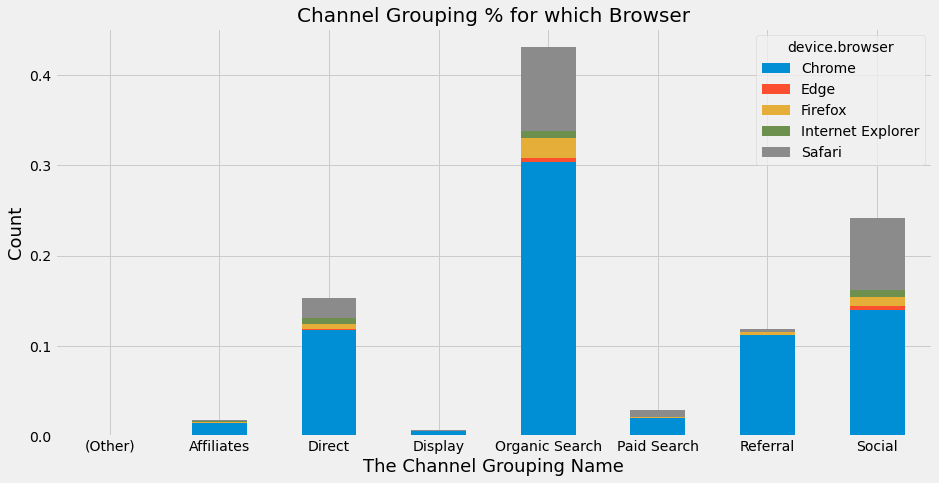

In [27]:
# I will use the crosstab to explore two categorical values

# select just the top 5 of browsers
crosstab_df = pd.crosstab(index=df['channelGrouping'], normalize=True,
                          columns=df[df['device.browser'].isin(df['device.browser']\
                                                                            .value_counts()[:5].index)]['device.browser'])


# Ploting the crosstab that we did above
crosstab_df.plot(kind="bar",
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Channel Grouping % for which Browser", fontsize=20) # seting the title size
plt.xlabel("The Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size
plt.xticks(rotation=0)
plt.show() # rendering

Very cool! Interesting patterns

# Operational System 

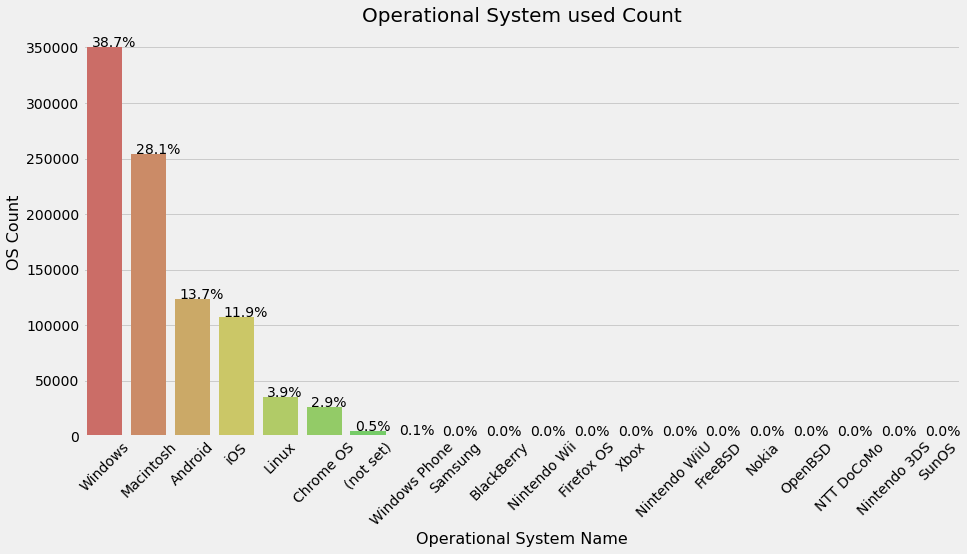

In [28]:
plt.figure(figsize=(14,7))

ax = sns.countplot(x="device.operatingSystem", data=df, palette="hls", order=df["device.operatingSystem"].value_counts().index)
total = len(df['device.operatingSystem'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + 0.1
        y = p.get_y() + p.get_height() + 200
        ax.annotate(percentage, (x, y))

plt.title("Operational System used Count", fontsize=20) # seting the title size
plt.xlabel("Operational System Name", fontsize=16) # seting the x label size
plt.ylabel("OS Count", fontsize=16) # seting the y label size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show()

## Now let's investigate the most used browser by Operational System

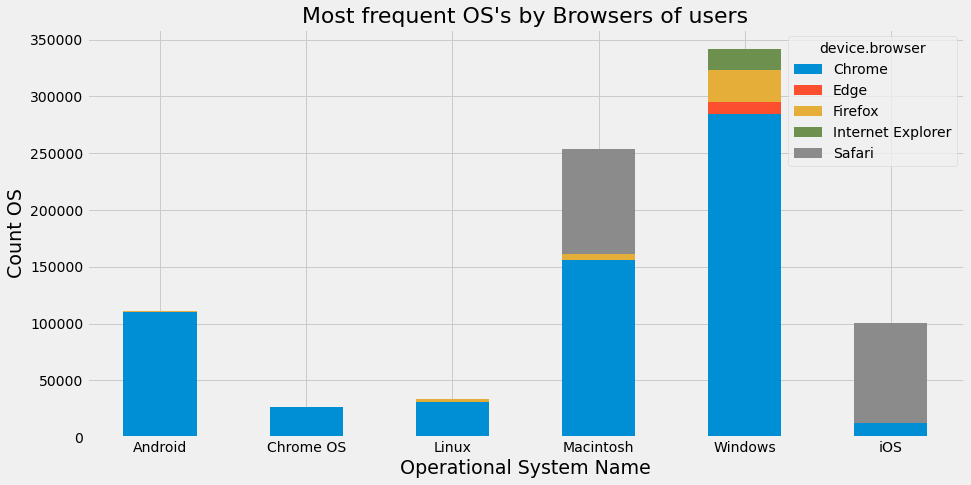

In [29]:
crosstab_df = pd.crosstab(index=df[df['device.operatingSystem']\
                                          .isin(df['device.operatingSystem']\
                                                .value_counts()[:6].index.values)]['device.operatingSystem'], 
                           
                           # select the top 5 of browsers
                           columns=df[df['device.browser'].isin(df['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])

crosstab_df.plot(kind="bar", figsize=(14,7), stacked=True) 
plt.title("Most frequent OS's by Browsers of users", fontsize=22) # adjusting title and fontsize
plt.xlabel("Operational System Name", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count OS", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=0) # Adjust the xticks, rotating the labels

plt.show()

## I will explore the distribution of transaction Revenue by each OS

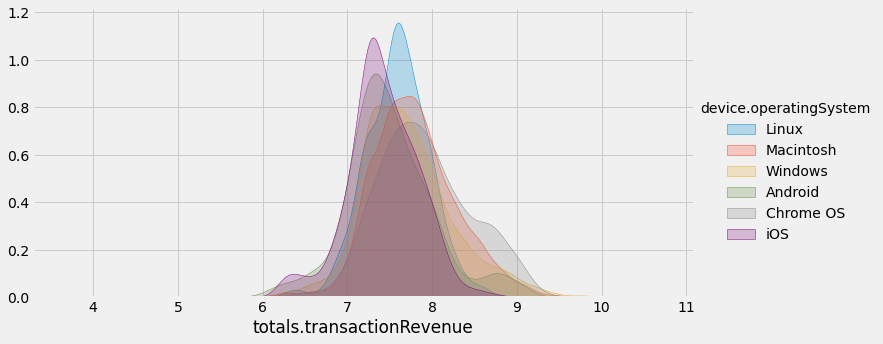

In [30]:
sns.FacetGrid(df[(df['device.operatingSystem']\
                        .isin(df['device.operatingSystem']\
                              .value_counts()[:6].index.values)) & df['totals.transactionRevenue'] > 0],
                               hue='device.operatingSystem', height=5, aspect=2)\
                .map(sns.kdeplot, 'totals.transactionRevenue', shade=True)\
                .add_legend()

plt.show()

Cool, we can have a better understanding of the distribution of Revenue by OS

## Let's investigate the Device Category

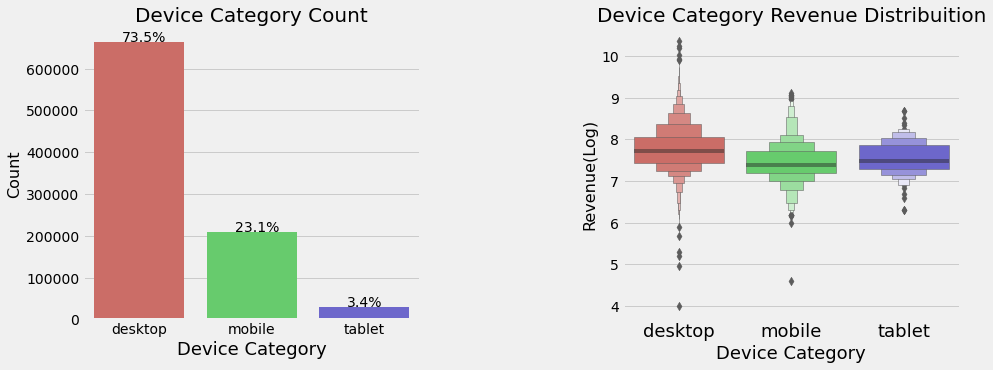

In [31]:
# seting the graph size
fig , ax = plt.subplots(1,2,figsize=(14,5))

sns.countplot(x="device.deviceCategory", data=df, palette="hls", ax = ax[0])
total = len(df['device.deviceCategory'])
for p in ax[0].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + 0.25
        y = p.get_y() + p.get_height() + 200
        ax[0].annotate(percentage, (x, y))
        
ax[0].set_title("Device Category Count", fontsize=20) # seting the title size
ax[0].set_xlabel("Device Category", fontsize=18) # seting the x label size
ax[0].set_ylabel("Count", fontsize=16) # seting the y label size
plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

sns.boxenplot(x="device.deviceCategory", y = 'totals.transactionRevenue', 
              data=df[df['totals.transactionRevenue'] > 0], palette="hls", ax=ax[1])

ax[1].set_title("Device Category Revenue Distribuition", fontsize=20) # seting the title size
ax[1].set_xlabel("Device Category", fontsize=18) # seting the x label size
ax[1].set_ylabel("Revenue(Log)", fontsize=16) # seting the y label size
plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

plt.subplots_adjust(wspace = 0.6)

plt.show()

## Let's see the difference distribution between Devices

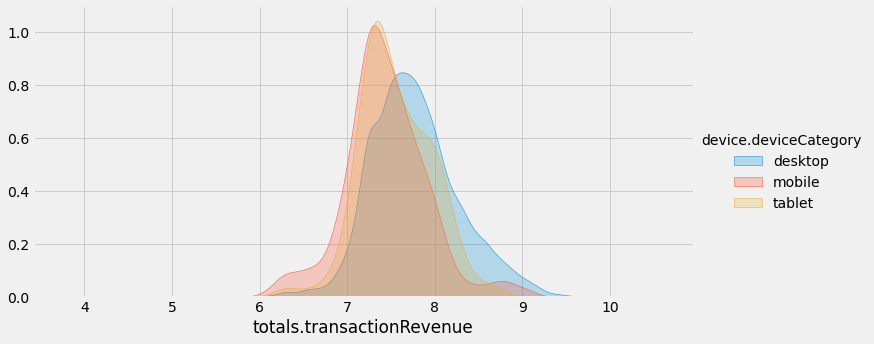

In [32]:
(sns.FacetGrid(df[df['totals.transactionRevenue'] > 0],
               hue='device.deviceCategory', height=5, aspect=2)
  .map(sns.kdeplot, 'totals.transactionRevenue', shade=True)
 .add_legend()
)
plt.show()

## Now, lets investigate the Device Category by Browsers

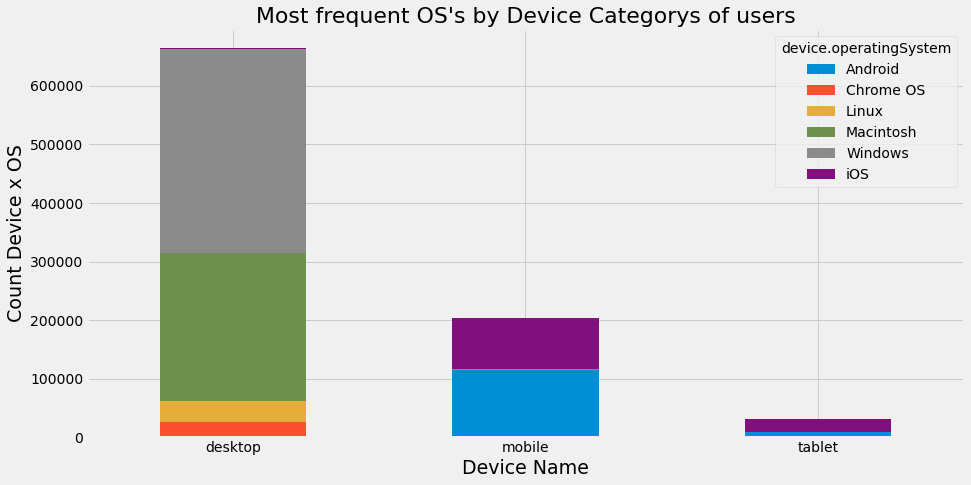

In [33]:
crosstab_df = pd.crosstab(index=df['device.deviceCategory'],
                           columns=df[df['device.operatingSystem']\
                                            .isin(df['device.operatingSystem']\
                                                  .value_counts()[:6].index)]['device.operatingSystem'])

crosstab_df.plot(kind="bar", figsize=(14,7), stacked=True)

plt.title("Most frequent OS's by Device Categorys of users", fontsize=22)
plt.xlabel("Device Name", fontsize=19)
plt.ylabel("Count Device x OS", fontsize=19)
plt.xticks(rotation=0)

plt.show()

# SubContinent 

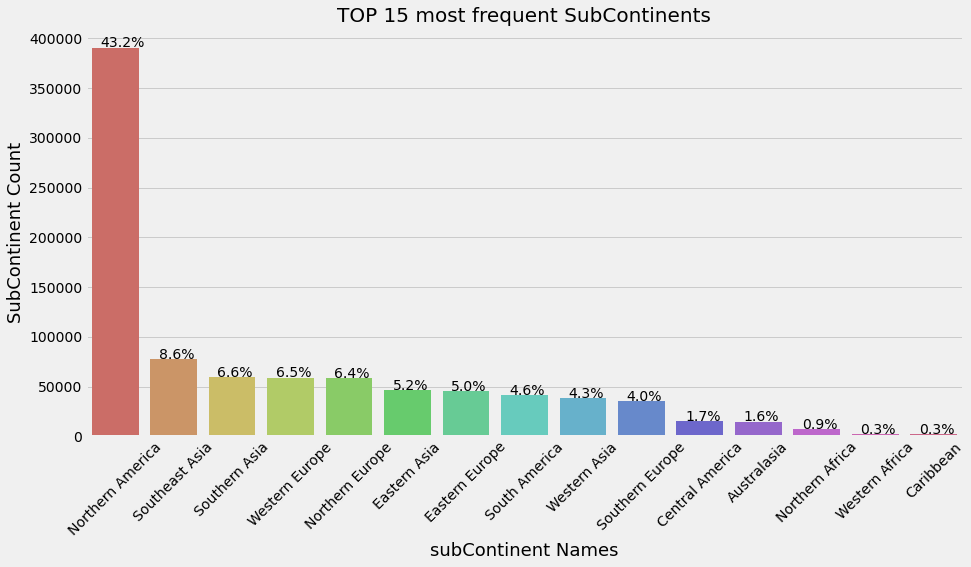

In [34]:
plt.figure(figsize=(14, 7))

ax = sns.countplot(x='geoNetwork.subContinent', data=df, order=df['geoNetwork.subContinent']\
                             .value_counts()[:15].index, palette="hls")

total = len(df['geoNetwork.subContinent'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + 0.15
        y = p.get_y() + p.get_height() + 200
        ax.annotate(percentage, (x, y))
        
plt.title("TOP 15 most frequent SubContinents", fontsize=20) # seting the title size
plt.xlabel("subContinent Names", fontsize=18) # seting the x label size
plt.ylabel("SubContinent Count", fontsize=18) # seting the y label size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show()

## Let's cross the SubContinent by Browser

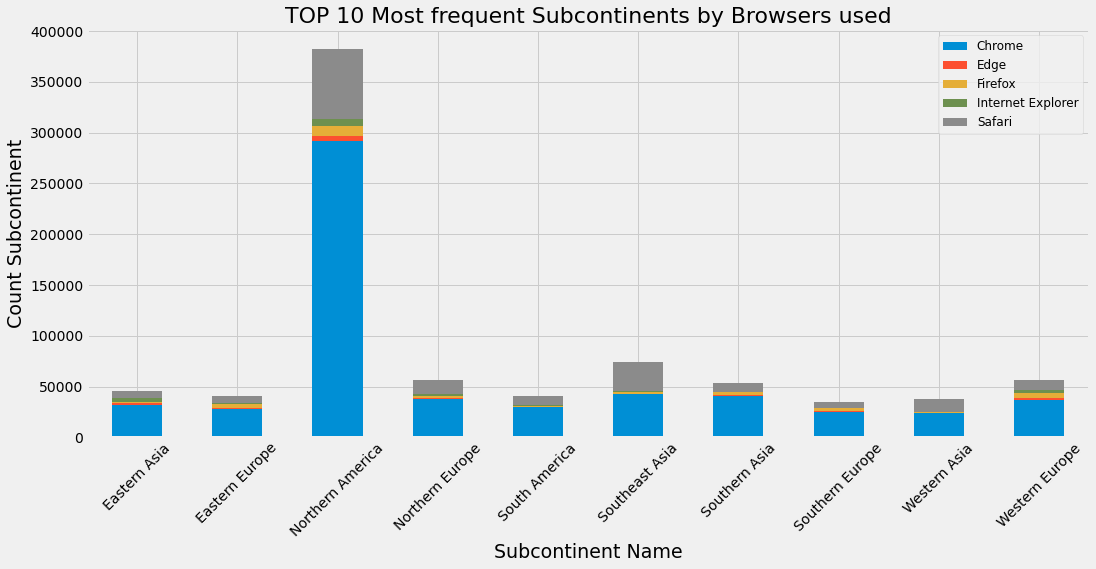

In [35]:
crosstab_df = pd.crosstab(index=df[df['geoNetwork.subContinent']\
                                          .isin(df['geoNetwork.subContinent']\
                                                .value_counts()[:10].index)]['geoNetwork.subContinent'], 
                           columns=df[df['device.browser'].isin(df['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])

crosstab_df.plot(kind="bar", figsize=(16,7), stacked=True)

plt.title("TOP 10 Most frequent Subcontinents by Browsers used", fontsize=22) # adjusting title and fontsize
plt.xlabel("Subcontinent Name", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count Subcontinent", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels
plt.legend(loc=1, prop={'size': 12})

plt.show()